# SciPy 2019 Tools Overview

## This notebook is an overview of tools mentioned in the SciPy 2019 Conference.
By Akira Sewnath

These tools are mostly for data science and data visualization.

# SatPy

A package originally designed for quickly generating high quality, high resolution satellite imagery.

### Reading data files

SatPy centers around the class "Scene". Data is loaded into a Scene via one of the readers available.

In [1]:
from satpy import Scene
from glob import glob

# Get the list of GOES-16 ABI files to open
filenames = glob('../data/abi_l1b/20180511_texas_fire_abi_l1b_conus/*.nc')
#filenames

In [2]:
#Check out available readers
from satpy import available_readers
sorted(available_readers())

Could not import reader config from: ['C:\\Users\\Akira\\Anaconda3\\envs\\pangeo\\lib\\site-packages\\satpy\\etc\\readers\\li_l2.yaml']
Could not import reader config from: ['C:\\Users\\Akira\\Anaconda3\\envs\\pangeo\\lib\\site-packages\\satpy\\etc\\readers\\clavrx.yaml']
Could not import reader config from: ['C:\\Users\\Akira\\Anaconda3\\envs\\pangeo\\lib\\site-packages\\satpy\\etc\\readers\\hsaf_grib.yaml']
Could not import reader config from: ['C:\\Users\\Akira\\Anaconda3\\envs\\pangeo\\lib\\site-packages\\satpy\\etc\\readers\\grib.yaml']
Could not import reader config from: ['C:\\Users\\Akira\\Anaconda3\\envs\\pangeo\\lib\\site-packages\\satpy\\etc\\readers\\msi_safe.yaml']
Could not import reader config from: ['C:\\Users\\Akira\\Anaconda3\\envs\\pangeo\\lib\\site-packages\\satpy\\etc\\readers\\caliop_l2_cloud.yaml']
Could not import reader config from: ['C:\\Users\\Akira\\Anaconda3\\envs\\pangeo\\lib\\site-packages\\satpy\\etc\\readers\\modis_l2.yaml']
Could not import reader conf

['abi_l1b',
 'abi_l1b_scmi',
 'acspo',
 'ahi_hrit',
 'ahi_hsd',
 'amsr2_l1b',
 'avhrr_l1b_aapp',
 'avhrr_l1b_eps',
 'electrol_hrit',
 'fci_l1c_fdhsi',
 'generic_image',
 'geocat',
 'ghrsst_l3c_sst',
 'goes-imager_hrit',
 'goes-imager_nc',
 'iasi_l2',
 'jami_hrit',
 'maia',
 'mersi2_l1b',
 'mtsat2-imager_hrit',
 'nucaps',
 'nwcsaf-geo',
 'nwcsaf-pps_nc',
 'olci_l1b',
 'olci_l2',
 'omps_edr',
 'safe_sar_l2_ocn',
 'sar-c_safe',
 'scatsat1_l2b',
 'seviri_l1b_hrit',
 'seviri_l1b_native',
 'seviri_l1b_nc',
 'slstr_l1b',
 'tropomi_l2',
 'vaisala_gld360',
 'viirs_compact',
 'viirs_edr_active_fires',
 'viirs_l1b',
 'viirs_sdr',
 'virr_l1b']

In [6]:
scn = Scene(reader='abi_l1b', filenames=filenames)
scn.keys()

[]

Files aren't actually loaded into scene until you explicitly load it.

In [7]:
scn.available_dataset_names()

['C01',
 'C02',
 'C03',
 'C04',
 'C05',
 'C06',
 'C07',
 'C08',
 'C09',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16']

The `Scene` is telling us that we have all 16 ABI channels available to load. This list includes any product that we can load from the file that the "abi_l1b" reader is configured to access. If we didn't provide all of the necessary files or the data was missing from the file for some reason, that product would not be listed here.

| Channel     | Wavelength  |  Resolution  |
| ----------- | ----------- |  ----------- |
| C01         | 0.47µm      |  1000m       |
| C02         | 0.64µm      |  250m        |
| C03         | 0.64µm      |  1000m       |
| C04         | 1.37µm      |  2000m       |
| C05         | 1.60µm      |  1000m       |
| C06         | 2.20µm      |  2000m       |
| C07         | 3.90µm      |  2000m       |
| C08         | 6.20µm      |  2000m       |
| C09         | 6.90µm      |  2000m       |
| C10         | 7.30µm      |  2000m       |
| C11         | 8.40µm      |  2000m       |
| C12         | 9.60µm      |  2000m       |
| C13         | 10.30µm     |  2000m       |
| C14         | 11.20µm     |  2000m       |
| C15         | 12.30µm     |  2000m       |
| C16         | 13.30µm     |  2000m       |

In [8]:
my_channel = 'C01'
scn.load([my_channel])
scn[my_channel]

<xarray.DataArray (y: 3000, x: 5000)>
dask.array<shape=(3000, 5000), dtype=float64, chunksize=(3000, 4096)>
Coordinates:
  * x        (x) float64 -3.627e+06 -3.626e+06 ... 1.381e+06 1.382e+06
  * y        (y) float64 4.589e+06 4.588e+06 4.587e+06 ... 1.585e+06 1.584e+06
Attributes:
    satellite_longitude:    -75.0
    satellite_latitude:     0.0
    satellite_altitude:     35786.0234375
    orbital_parameters:     {'projection_longitude': -75.0, 'projection_latit...
    cell_methods:           t: point area: point
    scene_id:               CONUS
    units:                  %
    name:                   C01
    modifiers:              ()
    platform_name:          GOES-16
    platform_shortname:     G16
    sensor_band_bit_depth:  10
    orbital_slot:           GOES-East
    standard_name:          toa_bidirectional_reflectance
    long_name:              Bidirectional Reflectance
    scan_mode:              M3
    observation_type:       Rad
    valid_range:            [   0 1022]


<img src="../pictures/dask.png">

<IPython.core.display.Javascript object>


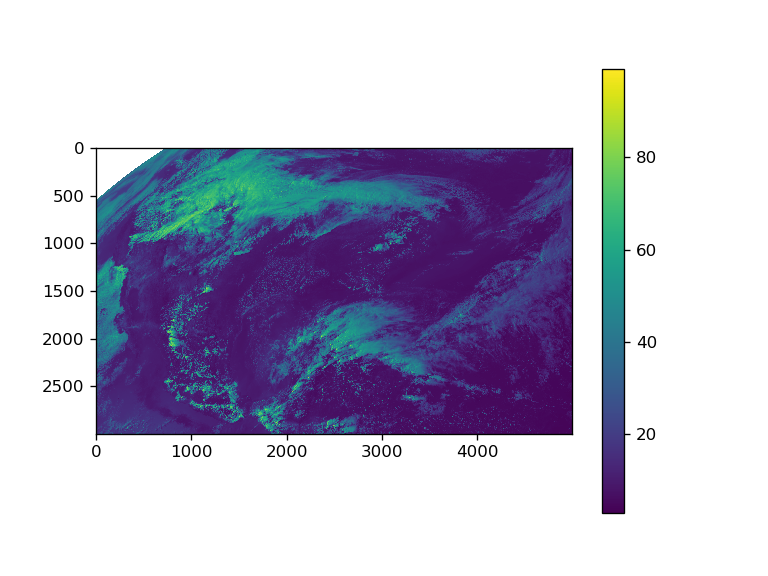

In [9]:
%matplotlib notebook

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(scn[my_channel])
plt.colorbar()

### Writing data files

In [10]:
from satpy import available_writers
sorted(available_writers())

Could not import writer config from: ['C:\\Users\\Akira\\Anaconda3\\envs\\pangeo\\lib\\site-packages\\satpy\\etc\\writers\\ninjotiff.yaml']


['cf', 'geotiff', 'mitiff', 'scmi', 'simple_image']

In [11]:
from dask.diagnostics import ProgressBar

with ProgressBar():
  scn.save_datasets()

[########################################] | 100% Completed |  5.2s


In [12]:
!pwd
!ls

'pwd' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


### Resampling

SatPy provides methods for resampling channels for comparison purposes or to change projections.

In [13]:
scn.load(['C05'])
scn['C05'].attrs['area']

Area ID: GOES-East
Description: 1km at nadir
Projection ID: abi_geos
Projection: {'a': '6378137.0', 'b': '6356752.31414', 'h': '35786023.0', 'lon_0': '-75.0', 'proj': 'geos', 'sweep': 'x', 'units': 'm'}
Number of columns: 5000
Number of rows: 3000
Area extent: (-3627271.3281, 1583173.5122, 1382771.9606, 4589199.4854)

In [14]:
scn.load(['C06'])
scn['C06'].attrs['area']

Area ID: GOES-East
Description: 2km at nadir
Projection ID: abi_geos
Projection: {'a': '6378137.0', 'b': '6356752.31414', 'h': '35786023.0', 'lon_0': '-75.0', 'proj': 'geos', 'sweep': 'x', 'units': 'm'}
Number of columns: 2500
Number of rows: 1500
Area extent: (-3627271.341, 1583173.7917, 1382771.9478, 4589199.7649)

The native resampler used has two possible operations:

1. If remapping data to a higher resolution, replicate each pixel to make the shape matches.
2. If remapping data to a lower resolution, average/aggregate the pixels to make the shapes match.

By default this resamples to the highest resolution area (smallest footprint per pixel) shared between the loaded datasets. You can easily specify the lower resolution by adding the argument `scn.min_area()`.

In [15]:
new_scn = scn.resample(resampler='native')
new_scn['C05'].shape == new_scn['C06'].shape

True

In [16]:
new_scn['C06'].attrs['area']

Area ID: GOES-East
Description: 1km at nadir
Projection ID: abi_geos
Projection: {'a': '6378137.0', 'b': '6356752.31414', 'h': '35786023.0', 'lon_0': '-75.0', 'proj': 'geos', 'sweep': 'x', 'units': 'm'}
Number of columns: 5000
Number of rows: 3000
Area extent: (-3627271.3281, 1583173.5122, 1382771.9606, 4589199.4854)

### Composites

In [17]:
scn.available_composite_names()

['airmass',
 'ash',
 'cloudtop',
 'convection',
 'day_microphysics',
 'dust',
 'fog',
 'green',
 'green_crefl',
 'green_raw',
 'green_snow',
 'ir108_3d',
 'ir_cloud_day',
 'natural_color',
 'natural_color_raw',
 'natural_color_sun',
 'night_fog',
 'night_microphysics',
 'overview',
 'overview_raw',
 'true_color',
 'true_color_crefl',
 'true_color_raw']

For this example, we will use the `airmass` preconfigured compsite. The airmass RGB is made of the following bands:

- R: C08 - C10
- G: C12 - C13
- B: C08

The red channel is the difference between the C08 (6.185µm) and C10 (7.34µm) bands, the green channel is the difference between the C12 (9.61µm) and C13 (10.35µm) bands, and the blue channel is the C08 (6.185µm) band.

In [18]:
scn.load(['airmass'])
scn['airmass']

<xarray.DataArray 'where-d106261527ca2f0f6e0cf5a4a88732cd' (bands: 3, y: 1500, x: 2500)>
dask.array<shape=(3, 1500, 2500), dtype=float64, chunksize=(1, 1500, 2500)>
Coordinates:
  * x        (x) float64 -3.626e+06 -3.624e+06 -3.622e+06 ... 1.38e+06 1.382e+06
  * y        (y) float64 4.588e+06 4.586e+06 4.584e+06 ... 1.586e+06 1.584e+06
  * bands    (bands) <U1 'R' 'G' 'B'
Attributes:
    cell_methods:            t: point area: point
    scene_id:                CONUS
    orbital_parameters:      {'projection_longitude': -75.0, 'projection_lati...
    platform_name:           GOES-16
    platform_shortname:      G16
    orbital_slot:            GOES-East
    standard_name:           airmass
    start_time:              2018-05-11 21:32:20.800000
    long_name:               Brightness Temperature
    scan_mode:               M3
    ancillary_variables:     []
    observation_type:        Rad
    polarization:            None
    level:                   None
    area:                   

<IPython.core.display.Javascript object>


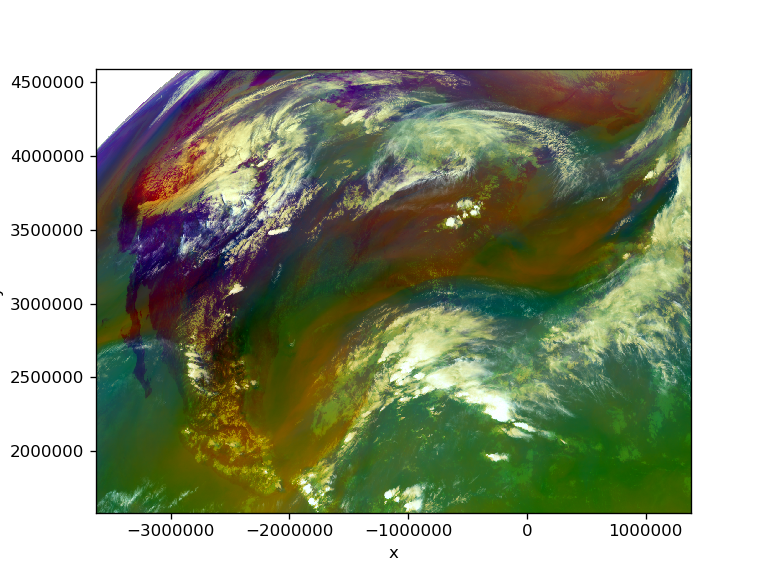

In [20]:
from satpy.writers import get_enhanced_image

plt.figure()
img = get_enhanced_image(scn['airmass'])
img_data = img.data
img_data.plot.imshow(rgb='bands', vmin=0, vmax=1)

## Geopandas

Extends pandas to create tools specifically for geospatial data

### Reading data

Explicitly creating geodata from flat text files. Data from [insideairbnb.com](https://insideairbnb.com).

In [57]:
import geopandas
import pandas
neighborhoods = pandas.read_csv('../data/neighborhoods.csv')
listings = pandas.read_csv('../data/listings.csv.gz')

For the first dataset, the `listings` data, records are provided with information about the latitude and longitude of the listing. You can use the latitude and longitude data to construct geometries required to create a `geodataframe`, a subclass of `pandas` dataframe useful for working with geographic data, directly from coordinates.

In [58]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,1078,https://www.airbnb.com/rooms/1078,20190514155147,2019-05-14,*UT/Hyde Park Craftsman Apartment,This upstairs apartment is surrounded by trees...,The garage apartment was built in the 1920s an...,This upstairs apartment is surrounded by trees...,none,"Hyde Park is close to downtown, UT, 6th street...",...,f,flexible,f,f,2,2,0,0,1.70,POINT (-97.73674 30.30123)
1,2265,https://www.airbnb.com/rooms/2265,20190514155147,2019-05-14,Zen-East in the Heart of Austin,Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,...,f,strict_14_with_grace_period,f,f,3,2,1,0,0.19,POINT (-97.71398000000001 30.2775)
2,5245,https://www.airbnb.com/rooms/5245,20190514155147,2019-05-14,"Green, Colorful, Clean & Cozy home",NaN,Situated in a vibrant & diverse multicultural ...,Situated in a vibrant & diverse multicultural ...,none,NaN,...,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07,POINT (-97.71379 30.27577)
3,5456,https://www.airbnb.com/rooms/5456,20190514155147,2019-05-14,"Walk to 6th, Rainey St and Convention Ctr",Fabulous location for walking to Convention Ce...,Cute Private Studio apartment located in Willo...,Fabulous location for walking to Convention Ce...,none,My neighborhood is ideally located if you want...,...,f,strict_14_with_grace_period,f,t,1,1,0,0,3.88,POINT (-97.73448 30.26112)
4,5769,https://www.airbnb.com/rooms/5769,20190514155147,2019-05-14,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...,...,f,moderate,t,t,1,0,1,0,2.22,POINT (-97.7837 30.45596)


In [23]:
list(listings.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_hood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'hood',
 'hood_cleansed',
 'hood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_p

The other dataset contains information about different regions in the Austin area.

In [59]:
neighborhoods.head()

,hood_id,hood_group,wkb
0,78739,NaN,01060000000100000001030000000100000077020000AC...
1,78754,NaN,01060000000100000001030000000100000074010000B1...
2,78732,NaN,0106000000010000000103000000010000009601000082...
3,78737,NaN,010600000001000000010300000001000000F1000000A4...
4,78756,NaN,010600000001000000010300000001000000DE0000007E...


*wkb*: well known binary representation of geographical information. Often, the well-known binary representation is a string of binary digits, encoded in hexidecimal, that represents the structure of the geometry corresponding to that record in the dataframe. Neighborhoods are "areal" features, meaning that they are polygons. Thus, the well-known binary column encodes the shape of these polygons.

### Creating Geometries from Raw Coordinates

Now we will turn both datasets into *geodataframes*. For the first dataset, `geopandas` has helper functions to construct a `geodataframe`. The `geodataframe` requires a `geoseries` called `geometry`.

In [60]:
geometries = geopandas.points_from_xy(listings.longitude, listings.latitude)

In [61]:
geometries

 ...]

In [62]:
listings = geopandas.GeoDataFrame(listings, geometry=geometries)
listings['geometry']

0                          POINT (-97.73674 30.30123)
1                  POINT (-97.71398000000001 30.2775)
2                          POINT (-97.71379 30.27577)
3                          POINT (-97.73448 30.26112)
4                           POINT (-97.7837 30.45596)
                             ...                     
11787                      POINT (-97.76137 30.25936)
11788              POINT (-97.72254000000001 30.2993)
11789             POINT (-97.67031999999999 30.44761)
11790                      POINT (-97.74642 30.25535)
11791    POINT (-97.72348000000001 30.29282000000001)
Name: geometry, Length: 11792, dtype: object

Creating a `geodataframe` for the neighborhoods dataset also requires us to explicitly define a `geometry`. This is done by reading in the wkb data using `shapely`.

In [64]:
from shapely import wkb
neighborhoods['geometry'] = neighborhoods.wkb.apply(lambda shape: wkb.loads(shape, hex=True))
neighborhoods

,hood_id,hood_group,wkb,geometry
0,78739,NaN,01060000000100000001030000000100000077020000AC...,"(POLYGON ((-97.890016 30.209412, -97.889286 30..."
1,78754,NaN,01060000000100000001030000000100000074010000B1...,"(POLYGON ((-97.636577 30.402658, -97.637538000..."
2,78732,NaN,0106000000010000000103000000010000009601000082...,"(POLYGON ((-97.87302800000001 30.438064, -97.8..."
3,78737,NaN,010600000001000000010300000001000000F1000000A4...,"(POLYGON ((-98.018756 30.241665, -98.016169 30..."
4,78756,NaN,010600000001000000010300000001000000DE0000007E...,"(POLYGON ((-97.72792200000001 30.329055, -97.7..."
5,78747,NaN,010600000001000000010300000001000000A5000000AF...,"(POLYGON ((-97.73617299999999 30.159865, -97.7..."
6,78751,NaN,010600000001000000010300000001000000820000002F...,"(POLYGON ((-97.706766 30.322105, -97.70693 30...."
7,78712,NaN,0106000000010000000103000000010000001A00000071...,"(POLYGON ((-97.733661 30.285364, -97.732949 30..."
8,78738,NaN,0106000000010000000103000000010000006506000049...,"(POLYGON ((-98.006219 30.360791, -98.004242 30..."
9,78725,NaN,010600000001000000010300000001000000A003000091...,"(POLYGON ((-97.62338200000001 30.264594, -97.6..."


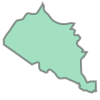

In [65]:
neighborhoods.geometry[0]

In [68]:
neighborhoods = geopandas.GeoDataFrame(neighborhoods)

Using basemap and contextily to create an image of the neighborhoods and AirBnB distributions. The coordinate reference system is set to the mercator projection for this. 

In [70]:
#neighborhoods.crs = {'init': 'epsg:3857'}
#listings.crs = {'init':'epsg:3857'}

In [71]:
#neighborhoods.total_bounds

In [39]:
#import contextily
#basemap, _ = contextily.bounds2img(*neighborhoods.total_bounds, zoom=10)

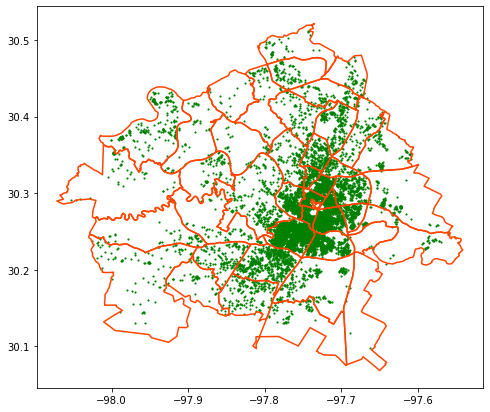

In [72]:
plt.figure(figsize=(8, 8))
neighborhoods.boundary.plot(ax=plt.gca(), color='orangered')
listings.plot(ax=plt.gca(), marker='.', markersize=5, color='green')

## Seaborn

Seaborne is a statistical visualization package in Python meant to quickly create attractive graphs.

<img src="../pictures/seaborn.png">

In [73]:
import libpysal as lp
import numpy
import contextily
import shapely.geometry as geom
import mapclassify
%matplotlib inline

In [75]:
df = geopandas.read_file('../data/neighborhoods.gpkg')
listings = geopandas.read_file('../data/listings.gpkg')
#preprocessing price
listings['price'] = listings.price.str.replace('$', '').str.replace(',','_').astype(float)

Code to aggregate the data within neighborhoods to look at median prices

In [76]:
median_price = geopandas.sjoin(listings[['price', 'geometry']], df, op='within')\
                  .groupby('index_right').price.median()
df['median_pri'] = median_price.values

In [77]:
df['median_pri'].fillna((df['median_pri'].mean()), inplace=True)
df.head()

,hood_id,hood_group,geometry,median_pri
0,78739,None,"(POLYGON ((-97.890016 30.209412, -97.889286 30...",150.0
1,78754,None,"(POLYGON ((-97.636577 30.402658, -97.637538000...",75.0
2,78732,None,"(POLYGON ((-97.87302800000001 30.438064, -97.8...",249.0
3,78737,None,"(POLYGON ((-98.018756 30.241665, -98.016169 30...",135.0
4,78756,None,"(POLYGON ((-97.72792200000001 30.329055, -97.7...",107.5


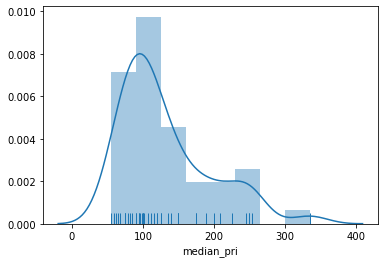

In [80]:
import seaborn as sbn
sbn.distplot(df['median_pri'], rug=True)

## GEODataFrame Chloropleth

`geodataframe` has a default chloropleth graph for spatially defined attributes.

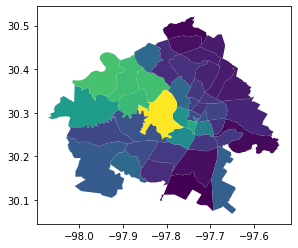

In [81]:
df.plot(column='median_pri')

## Rasterio

Package to access geospatial raster data

In [82]:
import rasterio
nightlight_file = rasterio.open('../data/txlights.tif')
nightlight_file

<open DatasetReader name='../data/txlights.tif' mode='r'>

Reading bands into array:

In [83]:
nightlights = nightlight_file.read(1)
nightlights

array([[0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 5, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

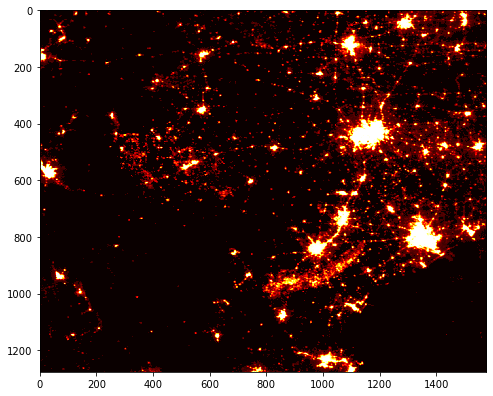

In [84]:
plt.figure(figsize=(8, 8))
plt.imshow(nightlights, cmap='hot')

## Glue Data Visualization

Glue is a GUI meant to aid data exploration through visualization tools. We're starting by loading the Iris dataset from [archive.uci.edu](https://archive.ics.uci.edu/ml/datasets.php). The data needed a little bit of preprocessing in order to create class subsets within Glue (changed class from string to integer).

In [54]:
data = pandas.read_csv('../data/iris.data', sep=" ", header=None)
data

,0
0,"5.1,3.5,1.4,0.2,0"
1,"4.9,3.0,1.4,0.2,0"
2,"4.7,3.2,1.3,0.2,0"
3,"4.6,3.1,1.5,0.2,0"
4,"5.0,3.6,1.4,0.2,0"
5,"5.4,3.9,1.7,0.4,0"
6,"4.6,3.4,1.4,0.3,0"
7,"5.0,3.4,1.5,0.2,0"
8,"4.4,2.9,1.4,0.2,0"
9,"4.9,3.1,1.5,0.1,0"


Here are a couple screen shots when the Iris data is in Glue. You can select different subsets and view them in different plots to get a better understanding of your data's characteristics.

<img src="../pictures/glue_3d_scatter.png">

<img src="../pictures/glue_multiple_windows.png">